In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
from sklearn.utils import shuffle
from wordcloud import WordCloud

import re
import string
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sreenidhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sreenidhi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression

# Preparing the Data

## Import the Dataset

In [3]:
tweets = pd.read_csv("tweets_dataset.csv", encoding='latin-1', names = ['label','id','date','noquery','handler','tweet'])

In [4]:
tweets.head()

,label,id,date,noquery,handler,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   label    1600000 non-null  int64 
 1   id       1600000 non-null  int64 
 2   date     1600000 non-null  object
 3   noquery  1600000 non-null  object
 4   handler  1600000 non-null  object
 5   tweet    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


### Remove unnecessary columns (columns not needed for algorithm)

In [6]:
tweets.drop(['id', 'date','noquery','handler'], axis=1, inplace=True)

In [7]:
tweets['length'] = tweets['tweet'].apply(len)

In [8]:
tweets['label'] = tweets['label'].map({0: 0, 4: 1})

In [9]:
tweets[tweets['length'] == 374]['tweet']

1295281    @catfish_ohm à¹à¸à¹à¸²à¹à¸«à¹à¸?à¸²à¸£à¹...
Name: tweet, dtype: object

In [73]:
tweets.head()

,label,tweet,length
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111


## Visualizing the Dataset

In [10]:
tweets_negative = tweets[tweets['label']==0]
tweets_positive = tweets[tweets['label']==1]

(0.0, 170.0)

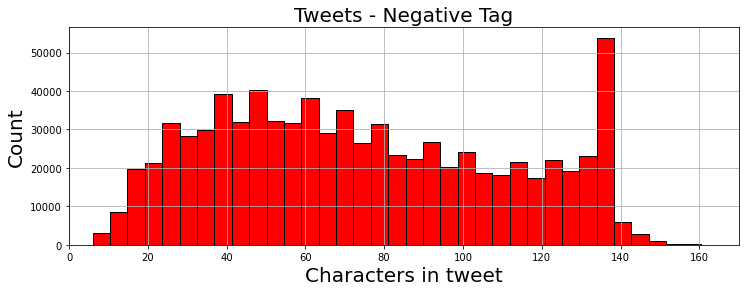

In [11]:
tweets_negative.hist(column='length', color = "red", ec="black", bins=80,figsize=(12,4))

plt.title('Tweets - Negative Tag', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Characters in tweet', fontsize = 20)
plt.xlim((0,170))

(0.0, 170.0)

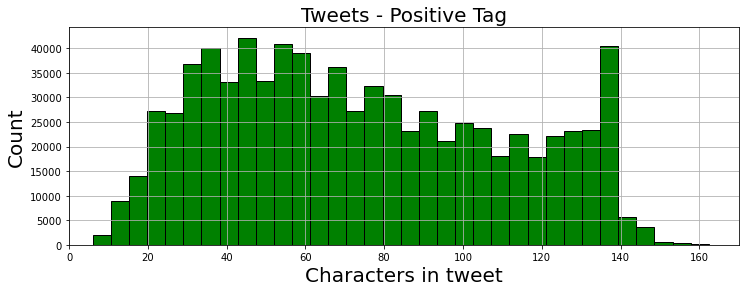

In [12]:
tweets_positive.hist(column='length', color = "green", ec="black", bins=80,figsize=(12,4))

plt.title('Tweets - Positive Tag', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Characters in tweet', fontsize = 20)
plt.xlim((0,170))

## Cleaning the data to fix word contractions and remove unknown symbols 

In [13]:
from nltk.stem import WordNetLemmatizer

to_tokenize = WordPunctTokenizer()

# Negation code referenced from Medium Blog post cited:
# https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/sentiment-analysis-is-bad/notebooks/Cleaning%20the%20Sentiment140%20data.ipynb
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')


In [14]:
# Use Beautiful Soup to clean and update the text
def cleaned_df(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    
    # change all characters to lowercase
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x  in to_tokenize.tokenize(letters_only) if len(x) > 1]
    
    # lemmatizing the words
    lemmer=WordNetLemmatizer()
    words=[' '.join([lemmer.lemmatize(word) for word in text.split(' ')]) for text in words]
    return (" ".join(words)).strip()

## Clean all 1,600,000 tweets

In [15]:
%%time
all_cleaned_tweets = []
for i in range(0,len(tweets)):                                                                   
    all_cleaned_tweets.append(cleaned_df(tweets['tweet'][i]))

CPU times: user 7min 45s, sys: 24.8 s, total: 8min 9s
Wall time: 8min 16s


In [16]:
len(all_cleaned_tweets)

1600000

In [17]:
cleaned_df = pd.DataFrame(all_cleaned_tweets,columns=['clean tweet'])
cleaned_df['label'] = tweets['label']

In [18]:
cleaned_df['label'].value_counts()

1    800000
0    800000
Name: label, dtype: int64

In [19]:
cleaned_df.to_csv('clean_tweet.csv',encoding='utf-8')

In [ ]:
csv = 'clean_tweet.csv'
cleaned_df = pd.read_csv(csv,index_col=0)
cleaned_df.head()

In [21]:
cleaned_df.head()

,clean tweet,label
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many time for the ball managed to save t...,0
3,my whole body feel itchy and like it on fire,0
4,no it not behaving at all mad why am here beca...,0


In [22]:
cleaned_df.dropna(inplace=True)
cleaned_df.reset_index(drop=True,inplace=True)
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   clean tweet  1600000 non-null  object
 1   label        1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [23]:
cleaned_df['label'].value_counts()

1    800000
0    800000
Name: label, dtype: int64

# Visualizing the cleaned dataset

In [24]:
cleaned_df['length'] = cleaned_df['clean tweet'].apply(len)

Text(0.5, 1.0, 'Post-Preprocessing data')

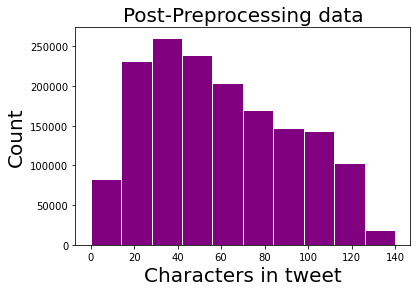

In [74]:
cleaned_df['length'].plot(kind='hist', color='purple', ec='white')
plt.xlabel('Characters in tweet', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Post-Preprocessing data', fontsize = 20)

## Visualizing using Word Cloud

In [26]:
tweets_negative_clean = cleaned_df[cleaned_df['label'] == 0]
str_negative = []
for t in tweets_negative_clean['clean tweet']:
     str_negative.append(t)
str_negative = pd.Series(str_negative).str.cat(sep=' ')

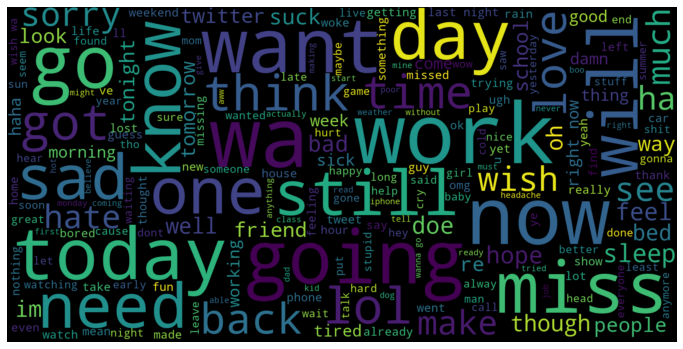

In [27]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(str_negative)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [28]:
tweets_positive_clean = cleaned_df[cleaned_df['label'] == 1]
str_positive = []
for t in tweets_positive_clean['clean tweet']:
    str_positive.append(t)
str_positive = pd.Series(str_positive).str.cat(sep=' ')

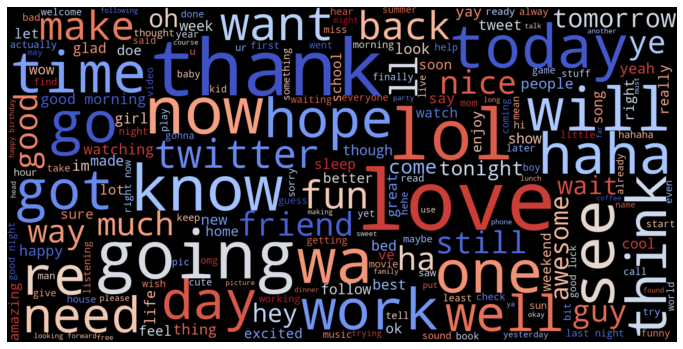

In [29]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap= 'coolwarm').generate(str_positive)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [30]:
cleaned_df = shuffle(cleaned_df)

In [31]:
cleaned_df.head()
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 633527 to 186848
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   clean tweet  1600000 non-null  object
 1   label        1600000 non-null  int64 
 2   length       1600000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 48.8+ MB


## Visualizing the top 200 tokens

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
c_vectorize = CountVectorizer()
c_vectorize.fit(cleaned_df['clean tweet'])

CountVectorizer()

In [33]:
matrix_negative = c_vectorize.transform(cleaned_df[cleaned_df['label'] == 0]['clean tweet'])
matrix_positive = c_vectorize.transform(cleaned_df[cleaned_df['label'] == 1]['clean tweet'])
neg_tf = np.sum(matrix_negative,axis=0)
pos_tf = np.sum(matrix_positive,axis=0)
negative_df = np.squeeze(np.asarray(neg_tf))
positive_df = np.squeeze(np.asarray(pos_tf))
tweet_dataframe = pd.DataFrame([negative_df,positive_df],columns=c_vectorize.get_feature_names()).transpose()

In [34]:
tweet_dataframe.columns = ['negative', 'positive']
tweet_dataframe['total'] = tweet_dataframe['negative'] + tweet_dataframe['positive']
tweet_dataframe.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313162,252567,565729
the,257836,265998,523834
it,182969,167030,349999
my,190775,125955,316730
and,153958,149642,303600
you,103844,198245,302089
not,194724,86861,281585
is,133432,111191,244623
in,115614,101223,216837
for,98999,117369,216368


Text(0.5, 1.0, 'Top 200 tokens')

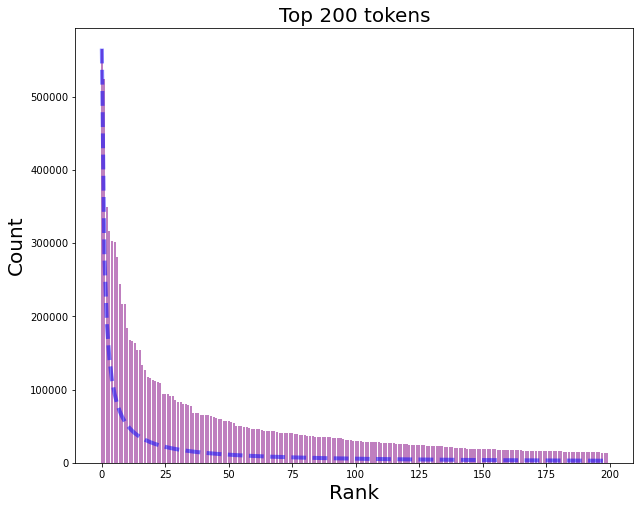

In [72]:
y_pos = np.arange(200)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [tweet_dataframe.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, tweet_dataframe.sort_values(by='total', ascending=False)['total'][:200], align='center', color = 'purple',alpha=0.5)
plt.plot(y_pos, expected_zipf, color='b', linestyle='--',linewidth=4,alpha=0.5)
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Rank', fontsize = 20)
plt.title('Top 200 tokens', fontsize = 20)

# Run algorithms and check with confusion matrix

## Null Accuracy

In [38]:
cleaned_top100 = cleaned_df.sample(n=100000, random_state=101)
from sklearn.model_selection import train_test_split
X = cleaned_top100['clean tweet']
y = cleaned_top100['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
nullaccuracy = max(y_test.mean(), y_test.mean())
print("Null Accuracy = ",nullaccuracy)

Null Accuracy =  0.49883333333333335


## Naive Bayes

In [46]:
cv = CountVectorizer(stop_words='english',max_features=10000)

In [48]:
X = cv.fit_transform(cleaned_top100['clean tweet'])
y = cleaned_top100['label']

In [51]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=101)
nb = MultinomialNB()
nb.fit(X_train,y_train)
predictions = nb.predict(X_test)

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print("Naive Bayes Accuracy = ", accuracy_score(y_test,predictions))

[[391 114]
 [143 352]]
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       505
           1       0.76      0.71      0.73       495

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000

Naive Bayes Accuracy =  0.743


## Linear Regression

In [55]:
count_vec = CountVectorizer(stop_words='english',max_features=10000)
X = count_vec.fit_transform(cleaned_top100['clean tweet'])
y = cleaned_top100['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
lr = LinearRegression()

In [63]:
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)

In [64]:
print("Mean Squared error: ",mean_squared_error(y_test,predictions))
print("Mean Absolute error: ",mean_absolute_error(y_test,predictions))
print ("R2 Score: ",r2_score(y_test,predictions))

Mean Squared error:  0.2082356978385214
Mean Absolute error:  0.38362576853343866
R2 Score:  0.1670526737104714


## Logistic Regression

In [65]:
count_vec = CountVectorizer(stop_words='english',max_features=10000)
X = count_vec.fit_transform(cleaned_top100['clean tweet'])
y = cleaned_top100['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
log_model = LogisticRegression(max_iter=3000)

In [66]:
log_model.fit(X=X_train, y=y_train)

LogisticRegression(max_iter=3000)

In [67]:
predictions = log_model.predict(X_test)

In [68]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions.round()))
print("Logistic Regression Accuracy: ",accuracy_score(y_test,predictions))

[[10798  4237]
 [ 3387 11578]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     15035
           1       0.73      0.77      0.75     14965

    accuracy                           0.75     30000
   macro avg       0.75      0.75      0.75     30000
weighted avg       0.75      0.75      0.75     30000

Logistic Regression Accuracy:  0.7458666666666667
